In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


def match_values(dicts,val):
    for i in list(dicts.keys()):
        if dicts[i] == val:
            return i

def cross_validated(data,fold,degree,lamb):
    rms = []
    n = len(data)//fold
    temp_data = list(data)
    for _ in range(fold):
        test = random.sample(temp_data,n)
        train = list(data)
        for i in test:
            train.remove(i)
            temp_data.remove(i)
        rms.append(rmse_calculator(train,test,degree,lamb))
    return sum(rms)/len(rms)


def nested_cross_validated(data,fold):
    rms = []
    n = len(data)//fold
    temp_data = list(data)
    for _ in range(fold):
        test = random.sample(temp_data,n)
        train_val = list(data)
        for i in test:
            train_val.remove(i)
            temp_data.remove(i)


        temp_train_val = list(train_val)
        n_nested = len(train_val)//fold
        deg = {}
        deg_avg = {}
        deg_sd = {}
        for i in range(1,11):
            deg[i] = []
            deg_avg[i] = []
            deg_sd[i] = []
        for _ in range(fold):
            val = random.sample(temp_train_val,n_nested)
            train = list(train_val)
            for i in val:
                train.remove(i)
                temp_train_val.remove(i)
            for degree in range(1,11):
                rmtemp = rmse_calculator(train,val,degree)
                deg[degree].append(rmtemp)

        for i in range(1,11):
            values = deg[i]
            avg = sum(values)/len(values)
            sd = (sum([(x-avg)**2 for x in values])/(len(values)-1))**(1/2)
            deg_avg[i].append(round(avg,4))
            deg_sd[i].append(round(sd,4)) 
        
        best_sd = min(deg_sd.values())
        best_avg = min(deg_avg.values())

        best_degree = match_values(deg_sd,best_sd)
        # best_degree = match_values(deg_avg,best_avg)
        # print(best_degree)
        rmstemp = rmse_calculator(train_val,test,best_degree)
        rms.append(rmstemp)
    return sum(rms)/len(rms)

            

def table(start,stop,maxseed,degree,noise):
    tb = {'Sample Size':[i for i in range(start,stop+1,10)],'Training':[],'CV':[]} 
    for i in range(start,stop+1,10):
        train_list = []
        cv_list = []
        # print(i)
        for seed in range(maxseed):
            data = generate_custom_sine_wave(i,seed,noise)
            train_rmse = rmse_calculator(data,data,degree)
            cv_rmse = cross_validated(data,5,degree)
            train_list.append(train_rmse)
            cv_list.append(cv_rmse)
        tb['Training'].append('%.4f'%(sum(train_list)/len(train_list)))
        tb['CV'].append('%.4f'%(sum(cv_list)/len(cv_list)))
    csv = pd.DataFrame(tb)
    return csv
    
        

def generate_custom_sine_wave(num_points,seed,noise=0):
    random.seed(seed)
    np.random.seed(seed)
    x = [random.uniform(-1,1) for _ in range(num_points)]
    # y = [np.sin(np.pi * i) for i in x]
    
    y = [np.sin(np.pi * i)+np.random.normal(0,noise,1)[0] for i in x]
    xy = [[x[i],y[i]] for i in range(num_points)]
    return xy

def rmse(coef,xy):
    data = []
    for i in xy:
        y_hat = 0
        for j in range(len(coef)):
            y_hat += coef.item(j)*i[0]**(j)
        rse = (y_hat-i[1])**2
        data.append(rse)
    return (sum(data)/(len(data)))

def rmse_calculator(train,test,degree,lamb):
    coef = normal_eq(train,degree,lamb)
    result = rmse(coef,test)
    return result

def normal_eq(xy,degree,lamb):
    xn = [i[0] for i in xy]
    yn = [i[1] for i in xy]
    x_mat = []  
    for i in range(degree+1):
        x_mat.append([x**i for x in xn])
    I = np.identity(degree+1)
    I[0][0] = 0
    mx = np.matrix(x_mat).transpose()
    my = np.matrix(yn).transpose()
    xT = mx.transpose()
    coef = np.linalg.lstsq((xT*mx+(lamb*I)),(xT*my))
    
    return coef[0]

def yli(x,coef):
    yl = []
    for i in x:
        y = 0
        for j in range(len(coef)):
            y += coef.item(j)*i**(j)
        yl.append(y)
    return yl

def variance(mean,coef,n,x):
    y = 0
    summean = 0
    for j in range(len(mean)):
        summean += mean[j]*x**j
    for i in range(n):
        sumcoef = 0 
        for j in range(len(coef)):
            sumcoef += coef[j][i]*x**j
        y += (sumcoef-summean)**2
    return y/n
        
def bias(mean,x,y):
    bi = []
    for i in range(len(x)):
        summean = 0
        for j in range(len(mean)):
            summean += mean[j]*x[i]**j
        bi.append((summean - y[i])**2)
    return sum(bi)/len(bi)
        

        







In [145]:
normal_eq([[1,4],[2,3],[3,2],[4,1]],2,0)

/var/folders/l4/g4063s6d1zjcwtjdwk0lyb9m0000gn/T/ipykernel_25960/3704298639.py:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef = np.linalg.lstsq((xT*mx+(lamb*I)),(xT*my))


matrix([[ 5.00000000e+00],
        [-1.00000000e+00],
        [-3.39331705e-14]])

/var/folders/l4/g4063s6d1zjcwtjdwk0lyb9m0000gn/T/ipykernel_25960/3704298639.py:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef = np.linalg.lstsq((xT*mx+(lamb*I)),(xT*my))


RMSE CV = 97.2876
RMSE TRAIN = 0.0000


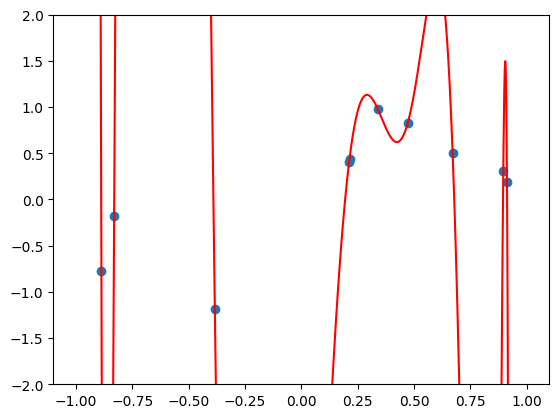

In [147]:
xy = generate_custom_sine_wave(10,2,0.2)
x_arr = [i[0] for i in xy]
y_arr = [i[1] for i in xy]
plt.scatter(x_arr,y_arr)
degree = 1000
lamb = 0
coef = normal_eq(xy,degree,lamb)
# coef = np.flip(np.polyfit(x_arr,y_arr,21))


print('RMSE CV =','%.4f'%cross_validated(xy,5,degree,lamb))
print('RMSE TRAIN =','%.4f'%rmse(coef,xy))
# print(cross_validated(xy,,1))
# y = 0
# x = sym.symbols('x')
# for i in range(len(coef)):
#     y += coef.item(i)*x**(i)
# print(sym.simplify(y))
lix = list(np.linspace(-1,1,10000))
# liy = [y.subs([(x,i)]) for i in lix]
liy = yli(lix,coef)
plt.ylim([-2,2])
plt.plot(lix,liy,color ='red')
plt.show()

/var/folders/l4/g4063s6d1zjcwtjdwk0lyb9m0000gn/T/ipykernel_25960/1714038690.py:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef = np.linalg.lstsq((xT*mx+(lamb*I)),(xT*my))


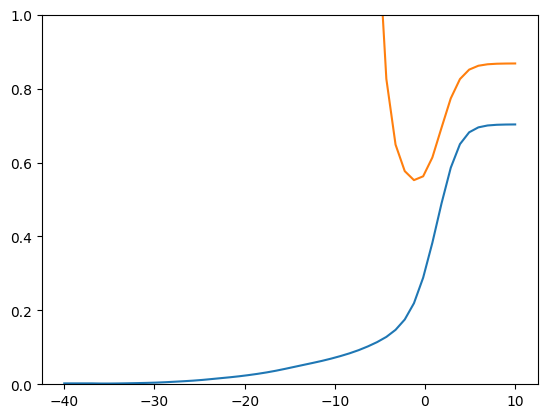

In [153]:
x = list(np.linspace(-40,10))
train = []
cv = []
for lnlam in x:
    ttemp = []
    cvtemp = []
    for seed in range(1,200):
        xy = generate_custom_sine_wave(10,seed,0.5)
        ttemp.append(rmse_calculator(xy,xy,9,np.e**lnlam))
        cvtemp.append(cross_validated(xy,5,9,np.e**lnlam))
    t = sum(ttemp)/len(ttemp)
    c = sum(cvtemp)/len(cvtemp)
    train.append(t)
    cv.append(c)

plt.ylim([0,1])
plt.plot(x,train)
plt.plot(x,cv)


In [3]:
def plotly(sample,degree,lamb,seeds,noise):
    xsin = np.linspace(-1,1)
    ysin = np.sin(np.pi*xsin)
    
    coefl = {}
    meancoefl = {}
    for j in range(degree+1):
        coefl[j] = []
    for seed in range(seeds):
        xy = generate_custom_sine_wave(sample,seed,noise)
        coef = normal_eq(xy,degree,lamb)
        xl = np.linspace(-1,1)
        yl = yli(xl,coef)
        for j in range(len(coef)):
            coefl[j].append(coef.item(j))
        plt.scatter([x[0] for x in xy],[y[1] for y in xy],s=5)
        plt.plot(xl,yl,color='red',linewidth=0.5)       
    plt.plot(xsin,ysin,color='blue') 
    plt.xlim([-1,1])
    plt.ylim([-2,2])  
    plt.show()

    for i in range(degree+1):
        coef = list(coefl[i])
        mean = sum(coef)/len(coef)
        meancoefl[i] = mean

    xl = list(np.linspace(-1,1))
    yl = []
    var = []
    for i in xl:
        y = 0
        for j in range(degree+1):
            y += meancoefl[j]*i**j
        yl.append(y)
        var.append(variance(meancoefl,coefl,seeds,i))
    

    
    plt.plot(xsin,ysin,color='blue') 
    plt.xlim([-1,1])
    plt.ylim([-2,2])   
    plt.fill_between(xl,[yl[i] - variance(meancoefl,coefl,seeds,xl[i])**(1/2) for i in range(len(xl))],[yl[i] + variance(meancoefl,coefl,seeds,xl[i])**(1/2) for i in range(len(xl))],color = 'gray')
    plt.plot(xl,yl,color='red')
    plt.show()   
    print('Variance = %.4f'%(sum(var)/len(var)))
    print('Bias = %.4f'%(bias(meancoefl,xsin,ysin)))



/var/folders/l4/g4063s6d1zjcwtjdwk0lyb9m0000gn/T/ipykernel_34315/2129588825.py:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef = np.linalg.lstsq((xT*mx+(lamb*I)),(xT*my))


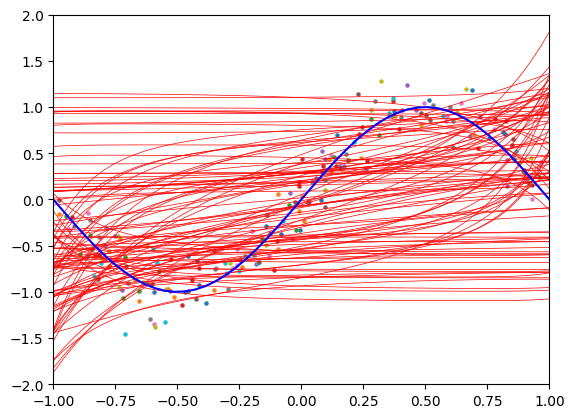

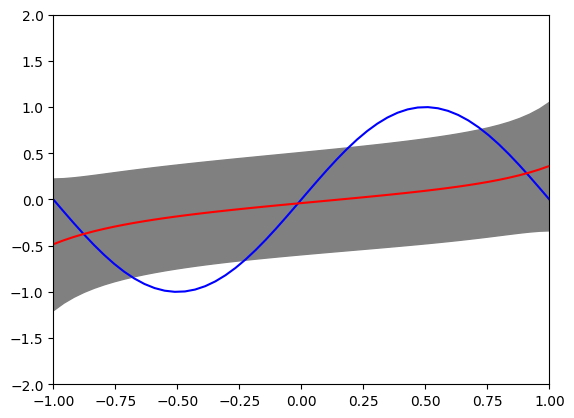

Variance = 0.3410
Bias = 0.3470


In [14]:
plotly(2,10,0.5,100,0.2)

In [21]:
I = np.identity(10)
I[0][0] = 0
I.size**(1/2)

10.0